In [2]:
import os, sys
import time
from pathlib import Path
from argparse import ArgumentParser
from tqdm.auto import tqdm
 
import yaml
import random, itertools
import numpy as np
import matplotlib.pyplot as plt
from typing import Union, Dict
 
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.nn.functional import kl_div, cross_entropy
 
from torch.utils.tensorboard import SummaryWriter
from torch.backends import cudnn
 
from models import get_model
from data import get_dataloader
 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
 
model_name = 'rnn'
batch_size = 1
 
dataset_kwargs = {
    'input_folder' : '/home/rtlink/robros/dataset/0215_norm/0215_collision/input_data', 
    'target_folder': '/home/rtlink/robros/dataset/0215_norm/0215_collision/target_data', 
    'collision_folder' : '/home/rtlink/robros/dataset/0215_norm/0215_collision/collision',
    'num_joints' : 7,
    'seq_len': 3000, 
    'offset' : 3000
}
 
validset = get_dataloader(name=model_name, train=False, **dataset_kwargs)
 
loader_kwargs = dict(
    batch_size=batch_size,
    drop_last=True
)
 
valid_loader = DataLoader(validset, **loader_kwargs)
 
ckpt_path = '/home/rtlink/robros/log/0221/rnn/hs100_nl40/ckpt.pt'
checkpoint = torch.load(ckpt_path, map_location=device)
model_CFG = checkpoint['cfg']
 
model_kwargs = dict(
    hidden_size=100,
    num_joints=7,
    num_layers=40,
    nhead=4,
    num_encoder_layers=6,
)
 
model_name = "rnn"
 
model = get_model(model_name, **model_kwargs).to(device)
model.eval()
 
# 저장할 텐서 초기화
predictions = []
targets = []
collisions = []

num_tests = 100
times = []
 
with torch.no_grad():
    for i, (input_data, target_data, collision_data) in zip(range(num_tests), valid_loader):
        input_data = input_data.to(device)
        target_data = target_data.to(device)  # 실제 데이터 로딩 추가
        start_time = time.time()
        predicted_data = model(input_data)
        end_time = time.time()
        times.append(end_time - start_time)
 
        # 결과 저장
        predictions.append(predicted_data)
        targets.append(target_data)
        collisions.append(collision_data)
 
 


In [4]:
print(predictions[0].size())

torch.Size([1, 7, 3000])


In [3]:
print(collisions[0].size())

torch.Size([1, 7, 3000])


In [13]:
print(predictions[0].squeeze()[1].size())

torch.Size([1000])


In [262]:
import matplotlib.pyplot as plt
import numpy as np
 
def plot_predictions_from_lists2(predictions, targets, index=0, sample_rate=10):
    """
    predictions와 targets 리스트에서 특정 인덱스의 데이터를 샘플링하여 시각화합니다.
    :param predictions: 예측값을 포함하는 리스트
    :param targets: 실제값을 포함하는 리스트
    :param index: 시각화하고자 하는 데이터의 인덱스
    :param sample_rate: 샘플링 비율 (기본값 10, 데이터 포인트 중 10개당 1개를 샘플링)
    """
    # 샘플링을 통해 데이터의 크기 줄이기
    sampled_predictions = predictions[index].squeeze()[5].cpu().numpy()[::sample_rate]
    sampled_targets = targets[index].squeeze()[5].cpu().numpy()[::sample_rate]
    plt.figure(figsize=(10, 7))
    plt.plot(sampled_predictions, label='Prediction', color='red')
    plt.plot(sampled_targets, label='Target', color='green')
    plt.legend()
    plt.title('Model Predictions vs. Targets (Sampled)')
    # plt.xlabel('Sampled Time Step')
    plt.ylabel('Value')
    plt.show()
 


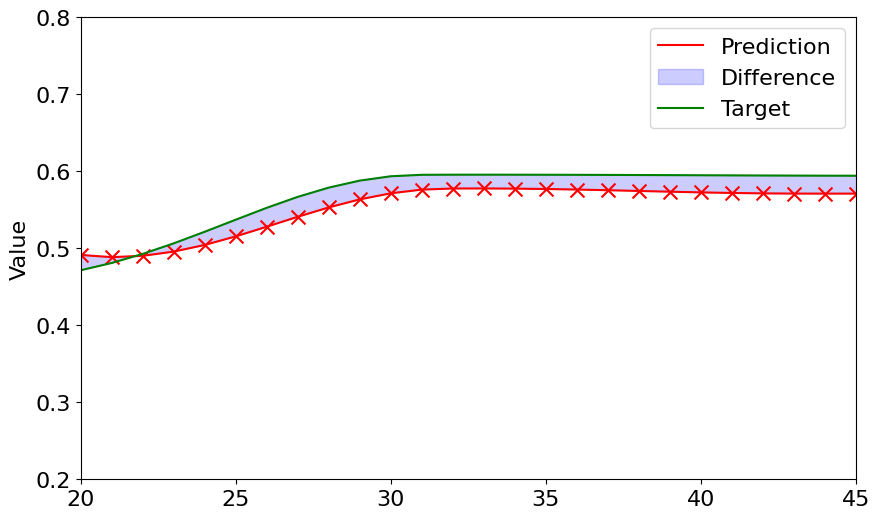

In [342]:
plot_predictions_from_lists2(predictions, targets, collisions, my_targets2, index=5, sample_rate=60)

In [341]:
import matplotlib.pyplot as plt
import numpy as np
 
def plot_predictions_from_lists2(predictions, targets, collisions, my_targets, index=0, sample_rate=10):
    """
    predictions, targets 리스트와 collisions 텐서에서 특정 인덱스의 데이터를 샘플링하여 시각화합니다.
    collisions 텐서는 targets의 각 포인트에 대한 마커 유형을 결정하는 데 사용됩니다.
    :param predictions: 예측값을 포함하는 리스트
    :param targets: 실제값을 포함하는 리스트
    :param collisions: 마커 유형을 결정하는 이진 텐서
    :param index: 시각화하고자 하는 데이터의 인덱스
    :param sample_rate: 샘플링 비율 (기본값 10, 데이터 포인트 중 10개당 1개를 샘플링)
    """
    # 샘플링을 통해 데이터의 크기 줄이기
    # targets_ori = targets[index].squeeze()[4].cpu().numpy()
    # sampled_predictions = predictions[index].squeeze()[4].cpu().numpy()[::sample_rate]
    sampled_targets = targets[index].squeeze()[4].cpu().numpy()[::sample_rate]
    sampled_collisions = collisions[index].squeeze()[4].cpu().numpy()[::sample_rate]

    targets_2 = targets[0].squeeze()[4].cpu().numpy()[::sample_rate]

    targets_2 = targets_2 - 2*(targets_2-0.5)+0.1
    plt.rcParams.update({'font.size': 16})


    sampled_collisions = np.zeros(len(sampled_collisions))

    plt.figure(figsize=(10, 6))

    plt.plot(targets_2, label='Prediction', color='red')
    plt.fill_between(range(len(my_targets)), targets_2, sampled_targets, color='blue', alpha=0.2, label='Difference')


    # plt.plot(sampled_predictions, label='Prediction', color='red')

 
    # targets에 대해 collisions 값에 따라 마커 유형 변경하여 표시
    for i, (targets_2, collision) in enumerate(zip(targets_2, sampled_collisions)):
        if collision == 0:
            plt.scatter(i, targets_2, color='red', marker='x', label='Prediction' if i == 0 else "", s=100)
        else:
            plt.scatter(i, targets_2, color='red', marker='o', label='Prediction' if i == 0 else "", s=100)
 
    # 범례는 중복되는 항목을 제거하고 표시
    plt.plot(sampled_targets, label='Target', color='green')
    plt.plot(targets_2, label='Prediction', color='red')
    # plt.plot(my_targets, label='Prediction', color='red')
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())

 
    # plt.title('Model Predictions ')
    # plt.xlabel('Sampled Time Step')
    plt.ylabel('Value')

    plt.ylim(0.2, 0.8)
    plt.xlim(20,45)

    plt.show()

In [349]:
import matplotlib.pyplot as plt
import numpy as np
 
def plot_predictions_from_lists(predictions, targets, collisions, my_targets, index=0, sample_rate=10):
    """
    predictions, targets 리스트와 collisions 텐서에서 특정 인덱스의 데이터를 샘플링하여 시각화합니다.
    collisions 텐서는 targets의 각 포인트에 대한 마커 유형을 결정하는 데 사용됩니다.
    :param predictions: 예측값을 포함하는 리스트
    :param targets: 실제값을 포함하는 리스트
    :param collisions: 마커 유형을 결정하는 이진 텐서
    :param index: 시각화하고자 하는 데이터의 인덱스
    :param sample_rate: 샘플링 비율 (기본값 10, 데이터 포인트 중 10개당 1개를 샘플링)
    """
    # 샘플링을 통해 데이터의 크기 줄이기
    # targets_ori = targets[index].squeeze()[4].cpu().numpy()
    # sampled_predictions = predictions[index].squeeze()[4].cpu().numpy()[::sample_rate]
    sampled_targets = targets[index].squeeze()[4].cpu().numpy()[::sample_rate]
    sampled_collisions = collisions[index].squeeze()[4].cpu().numpy()[::sample_rate]

    print(sampled_collisions[34])
    sampled_collisions[34] = 1
    sampled_collisions[33] = 1
    plt.rcParams.update({'font.size': 16})
    plt.figure(figsize=(10, 6))

    plt.plot(my_targets, label='Prediction', color='red')

    # plt.plot(sampled_predictions, label='Prediction', color='red')
 
    # targets에 대해 collisions 값에 따라 마커 유형 변경하여 표시
    for i, (my_targets, collision) in enumerate(zip(my_targets, sampled_collisions)):
        if collision == 0:
            plt.scatter(i, my_targets, color='red', marker='o', label='Prediction' if i == 0 else "", s=100)
        else:
            plt.scatter(i, my_targets, color='red', marker='x', label='Prediction' if i == 0 else "", s=100)
 
    # 범례는 중복되는 항목을 제거하고 표시
    plt.plot(sampled_targets, label='Target', color='green')


    plt.plot(my_targets, label='Prediction', color='red')
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())


    plt.ylabel('Value')

    plt.ylim(0.2, 0.8)
    plt.xlim(20,45)

    plt.show()

0.0


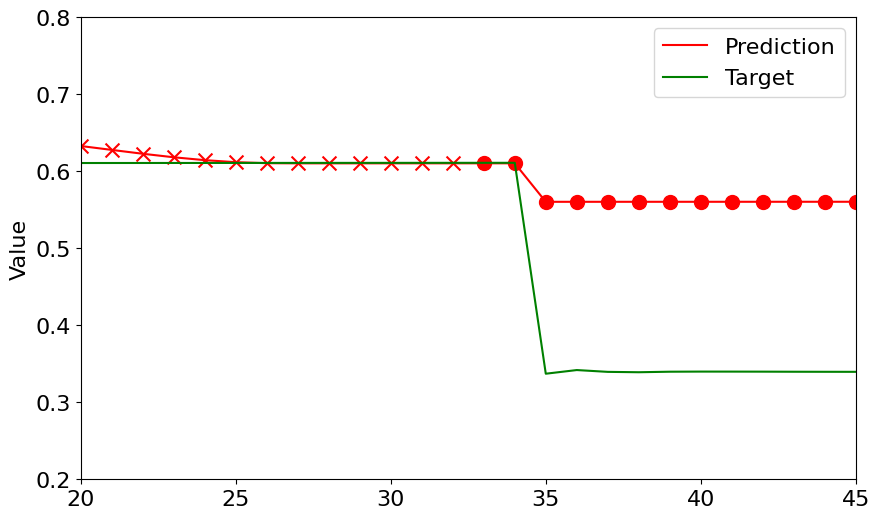

In [344]:
plot_predictions_from_lists(predictions, targets, collisions, my_targets3, index=6, sample_rate=60)

In [345]:
import matplotlib.pyplot as plt
import numpy as np
 
def plot_predictions_from_lists3(predictions, targets, collisions, my_targets, index=0, sample_rate=10):
    """
    predictions, targets 리스트와 collisions 텐서에서 특정 인덱스의 데이터를 샘플링하여 시각화합니다.
    collisions 텐서는 targets의 각 포인트에 대한 마커 유형을 결정하는 데 사용됩니다.
    :param predictions: 예측값을 포함하는 리스트
    :param targets: 실제값을 포함하는 리스트
    :param collisions: 마커 유형을 결정하는 이진 텐서
    :param index: 시각화하고자 하는 데이터의 인덱스
    :param sample_rate: 샘플링 비율 (기본값 10, 데이터 포인트 중 10개당 1개를 샘플링)
    """
    sampled_targets = targets[index].squeeze()[4].cpu().numpy()[::sample_rate]
    sampled_collisions = collisions[index].squeeze()[4].cpu().numpy()[::sample_rate]

    sampled_collisions[34] = 0 
    sampled_collisions[33] = 0

    my_targets3[:35] = my_targets3[:35]+0.05
 
    plt.rcParams.update({'font.size': 16})
    plt.figure(figsize=(10, 6))
    plt.plot(my_targets, label='Prediction', color='red')

    # targets와 my_targets 간 차이 영역 색칠
    plt.fill_between(range(len(my_targets)), my_targets, sampled_targets, color='blue', alpha=0.2, label='Difference')
 
    # targets에 대해 collisions 값에 따라 마커 유형 변경하여 표시
    for i, (my_targets, collision) in enumerate(zip(my_targets, sampled_collisions)):
        if collision == 0:
            plt.scatter(i, my_targets, color='red', marker='x', label='Prediction' if i == 0 else "", s=100)
        else:
            plt.scatter(i, my_targets, color='red', marker='o', label='Prediction' if i == 0 else "", s=100)
 
    # 실제 targets 그리기
    plt.plot(sampled_targets, label='Target', color='green')
 
    # 예측값 my_targets 그리기
    plt.plot(my_targets, label='Prediction', color='red')
 
    # 범례 설정
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
 
    plt.ylabel('Value')
    plt.ylim(0.2, 0.8)
    plt.xlim(20, 45)
 
    plt.show()

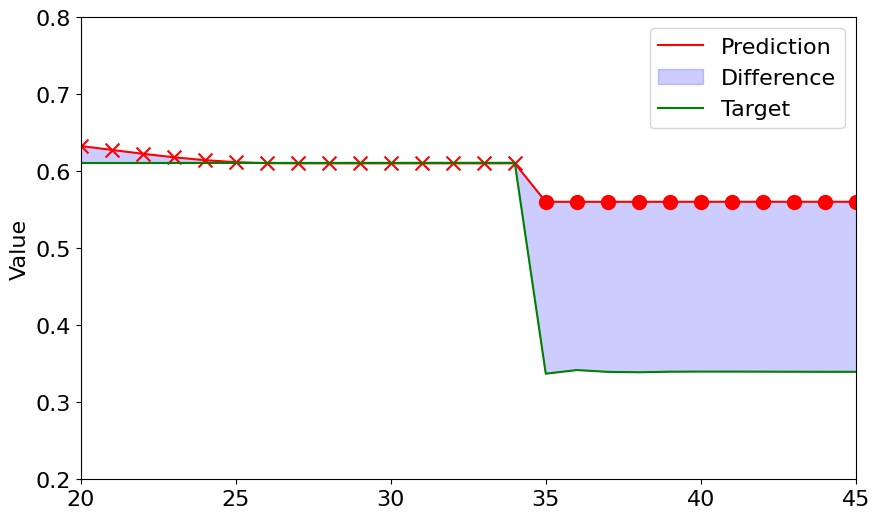

In [348]:
plot_predictions_from_lists3(predictions, targets, collisions, my_targets3, index=6, sample_rate=60)

0.0


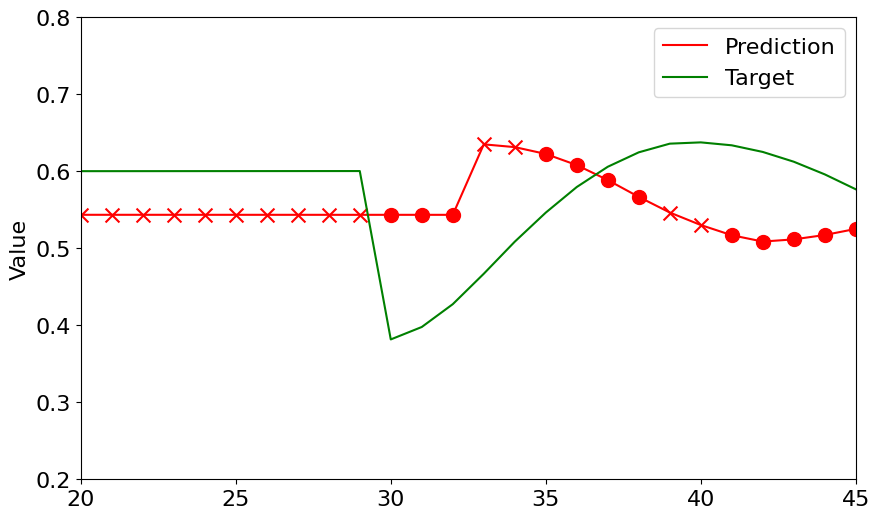

In [350]:
plot_predictions_from_lists(predictions, targets, collisions, my_targets, index=11, sample_rate=60)

In [171]:
my_targets = targets[19].squeeze()[4].cpu().numpy()[::60]
my_collisions = collisions[19].squeeze()[4].cpu().numpy()[::60]

In [347]:
my_targets3 = targets[18].squeeze()[4].cpu().numpy()[::60]


In [172]:
my_targets2 =my_targets+0.05

In [176]:
print(len(my_targets))

50


In [296]:
print(my_targets2)

[0.5935575  0.59355384 0.59355015 0.5935465  0.5935428  0.5935392
 0.5935355  0.5935318  0.59352815 0.59352446 0.59352076 0.5935171
 0.5935134  0.59350973 0.5935061  0.5935024  0.5934987  0.5934951
 0.5934914  0.5934877  0.59348404 0.59348035 0.59347665 0.593473
 0.5934693  0.5934656  0.593462   0.5934583  0.5934546  0.59345096
 0.59344727 0.5934436  0.59343994 0.2575107  0.2593111  0.2637509
 0.27098602 0.28070664 0.2916249  0.30177513 0.30989665 0.31652588
 0.32063618 0.31921878 0.31637898 0.31241864 0.30767998 0.3024527
 0.31635487 0.31635487]


In [183]:
my_targets2[49] = my_targets2[49]-0.3

In [134]:
print(my_targets2[33])

0.6849786


In [164]:
extract_list = []
for i in range(15):
    dic = my_targets2[33+i]-0.4
    print(dic)
    extract_list.append(dic)

0.2849786043167114
0.2813777685165405
0.2724981665611267
0.2580279469490051
0.23858669996261594
0.21675018072128294
0.19644973278045652
0.1802066922187805
0.1669482350349426
0.1587276220321655
0.16156241893768308
0.1672420263290405
0.17516270875930784
0.18464002609252927
0.19509456157684324


In [145]:
print(extract_list)

[0.2849786043167114, 0.2813777685165405, 0.2724981665611267, 0.2580279469490051, 0.23858669996261594, 0.21675018072128294, 0.19644973278045652, 0.1802066922187805, 0.1669482350349426, 0.1587276220321655, 0.16156241893768308, 0.1672420263290405, 0.17516270875930784, 0.18464002609252927, 0.19509456157684324]


In [ ]:
my_targets2[33:] =my_targets2[33:]+0.05

In [173]:
for i in range(15):
    my_targets2[33+i] = my_targets2[33+i]-1.5*extract_list[i]